In [1]:
'''
Author: Chuyang Su cs4570@columbia.edu
Date: 2025-12-01 13:52:55
LastEditors: Schuyn 98257102+Schuyn@users.noreply.github.com
LastEditTime: 2025-12-01 14:04:44
FilePath: /Unsupervised-Machine-Learning-Final-Project/Code/main.ipynb
Description: 

'''
import sys
sys.path.append('.')

## Data Preprocessing

### 1. Split the data and fill the missing values.

In [2]:
from Data_preprocessing import NBADataPreprocessor

# Initialize
preprocessor = NBADataPreprocessor(
    data_path='Data/nbaplayersdraft.csv',
    validation_year=2021
)

# Run pipeline
df_train, df_validation = preprocessor.run_pipeline(missing_value_strategy='preserve_busts')

# Access separated features
feature_groups_train = preprocessor.separate_features(df_train)
X_modeling = feature_groups_train['modeling_numeric']
X_display = feature_groups_train['display_advanced']


Loaded 1922 players from 1989 to 2021
Total columns: 24
Training set: 1862 players (1989-2020)
Validation set: 60 players (2021)
                   Column  Missing_Count  Missing_Percentage Data_Type
       3_point_percentage            366               19.66   float64
                  college            328               17.62    object
    free_throw_percentage            279               14.98   float64
    field_goal_percentage            249               13.37   float64
           box_plus_minus            247               13.27   float64
win_shares_per_48_minutes            247               13.27   float64
                  assists            246               13.21   float64
               win_shares            246               13.21   float64
          average_assists            246               13.21   float64
   average_total_rebounds            246               13.21   float64
          points_per_game            246               13.21   float64
   average_minutes_

### 2. Feature Engineering

Using config to control the way to organize features. Also scale the features.

Before feature engineering, let's understand the college distribution to choose appropriate `college_top_n` value.

In [3]:
# Analyze college distribution (using existing df_train)
college_counts = df_train['college'].value_counts()

print("="*80)
print("COLLEGE DISTRIBUTION ANALYSIS")
print("="*80)
print(f"Total unique colleges: {df_train['college'].nunique()}")
print(f"Total players in training set: {len(df_train)}")

print("\n" + "="*80)
print("TOP 30 COLLEGES")
print("="*80)
for rank, (college, count) in enumerate(college_counts.head(30).items(), 1):
    pct = (count / len(df_train)) * 100
    print(f"{rank:2d}. {college:30s} - {count:3d} players ({pct:5.2f}%)")

print("\n" + "="*80)
print("COVERAGE BY TOP N")
print("="*80)
for n in [10, 20, 30, 50]:
    coverage = college_counts.head(n).sum()
    pct = (coverage / len(df_train)) * 100
    min_count = college_counts.head(n).min()
    print(f"Top {n:2d}: {coverage:4d}/{len(df_train)} players ({pct:5.2f}%) - min {min_count} players/college")

print("\n" + "="*80)
print("LONG TAIL")
print("="*80)
print(f"Colleges with 1 player: {(college_counts == 1).sum()}")
print(f"Colleges with 2 players: {(college_counts == 2).sum()}")
print(f"Colleges with 3-5 players: {((college_counts >= 3) & (college_counts <= 5)).sum()}")
print(f"Colleges with 6+ players: {(college_counts >= 6).sum()}")

COLLEGE DISTRIBUTION ANALYSIS
Total unique colleges: 238
Total players in training set: 1862

TOP 30 COLLEGES
 1. International                  - 328 players (17.62%)
 2. Duke                           -  56 players ( 3.01%)
 3. Kentucky                       -  56 players ( 3.01%)
 4. Arizona                        -  43 players ( 2.31%)
 5. UNC                            -  42 players ( 2.26%)
 6. UCLA                           -  42 players ( 2.26%)
 7. Kansas                         -  40 players ( 2.15%)
 8. UConn                          -  30 players ( 1.61%)
 9. Syracuse                       -  30 players ( 1.61%)
10. Michigan                       -  27 players ( 1.45%)
11. Michigan State                 -  27 players ( 1.45%)
12. Texas                          -  26 players ( 1.40%)
13. Maryland                       -  25 players ( 1.34%)
14. Georgia Tech                   -  24 players ( 1.29%)
15. Florida State                  -  22 players ( 1.18%)
16. Louisville      

In all, we decide to choose 20 as the number of colleges, because top 20 colleges explained 50% players.

In [6]:
from Feature_engineering import NBAFeatureEngineer

numeric_cols = [
    'games', 'minutes_played', 'points', 'total_rebounds', 'assists',
    'field_goal_percentage', '3_point_percentage', 'free_throw_percentage'
]

config_full = {
    'use_year': True,
    'use_team': True,
    'use_college': True,
    'college_top_n': 20,
    'scale_features': True,
    'include_draft_pick': True
}

fe_full = NBAFeatureEngineer(config_full)
X_train_full = fe_full.fit_transform(df_train, numeric_cols)
X_val_full = fe_full.transform(df_validation, numeric_cols)

fe_full.save_artifacts('Data/processed/features_full')

Added 8 numeric features
Added draft pick
Added year (normalized)
Added 38 team features (one-hot)
  Identified 20 top colleges
Added 21 college features (grouped + one-hot)

Final feature matrix shape: (1862, 69)
Total features: 69

Features scaled using StandardScaler
Added 8 numeric features
Added draft pick
Added year (normalized)

Final feature matrix shape: (60, 69)
Total features: 69

Features transformed using fitted scaler

Artifacts saved to Data/processed/features_full


In [7]:
config_numeric = {
    'use_year': False,           # Drop year
    'use_team': False,           # Drop team
    'use_college': False,        # Drop college
    'scale_features': True,
    'include_draft_pick': False  # Drop draft pick as well
}

fe_numeric = NBAFeatureEngineer(config_numeric)
X_train_numeric = fe_numeric.fit_transform(df_train, numeric_cols)
X_val_numeric = fe_numeric.transform(df_validation, numeric_cols)

fe_numeric.save_artifacts('Data/processed/features_numeric')

Added 8 numeric features

Final feature matrix shape: (1862, 8)
Total features: 8

Features scaled using StandardScaler
Added 8 numeric features

Final feature matrix shape: (60, 8)
Total features: 8

Features transformed using fitted scaler

Artifacts saved to Data/processed/features_numeric


### 3. PCA Analysis and Visualization

Perform PCA on training data (excluding advanced metrics) to determine dimensionality.


FITTING PCA
Input shape: (1862, 69)
Total components: 69
PCA fitting complete!

EXPLAINED VARIANCE STATISTICS
Components for 80% variance: 46 (actual: 80.59%)
Components for 85% variance: 50 (actual: 85.81%)
Components for 90% variance: 54 (actual: 90.81%)
Components for 95% variance: 58 (actual: 95.51%)

First 10 components:
  PC1: 8.06% (cumulative: 8.06%)
  PC2: 2.85% (cumulative: 10.91%)
  PC3: 2.48% (cumulative: 13.39%)
  PC4: 1.95% (cumulative: 15.34%)
  PC5: 1.82% (cumulative: 17.16%)
  PC6: 1.80% (cumulative: 18.96%)
  PC7: 1.78% (cumulative: 20.74%)
  PC8: 1.76% (cumulative: 22.50%)
  PC9: 1.74% (cumulative: 24.24%)
  PC10: 1.73% (cumulative: 25.97%)

CREATING EXPLAINED VARIANCE PLOTS


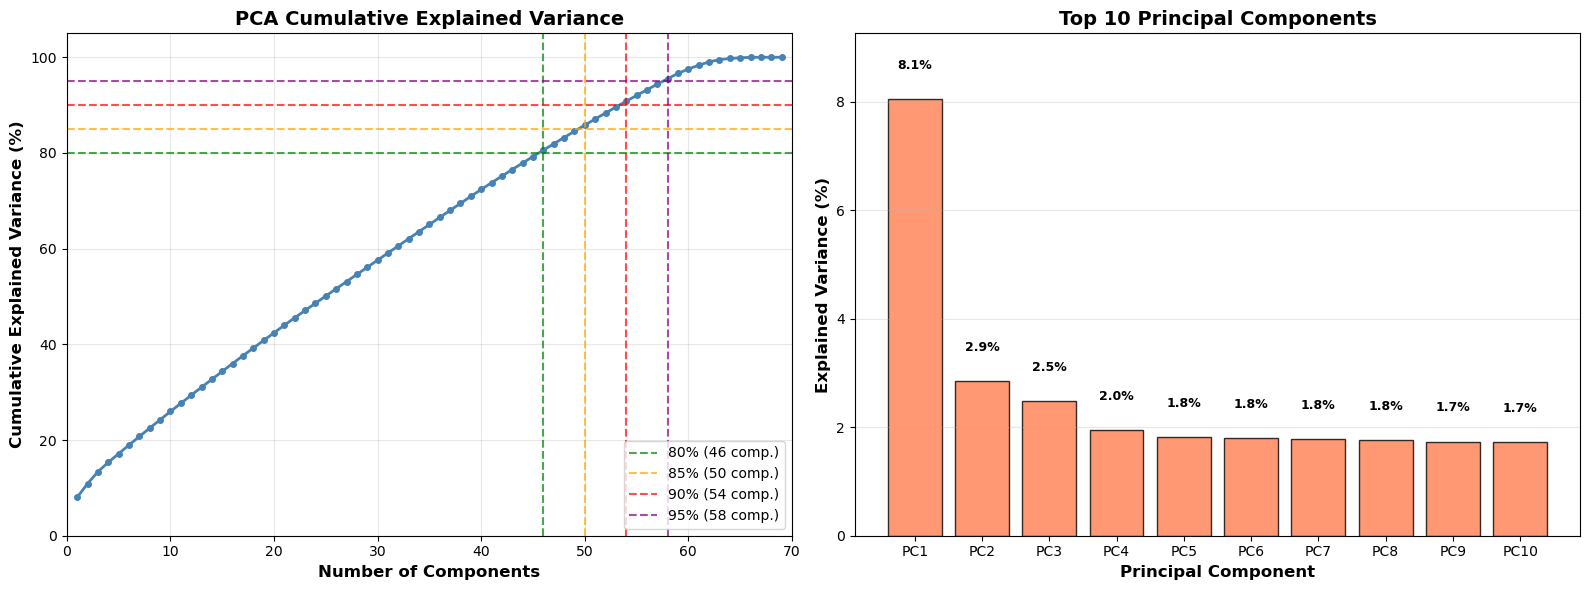

Saved: Latex/Figure/pca_explained_variance.png
Saved: Latex/Figure/pca_explained_variance.pdf

CREATING SCREE PLOT


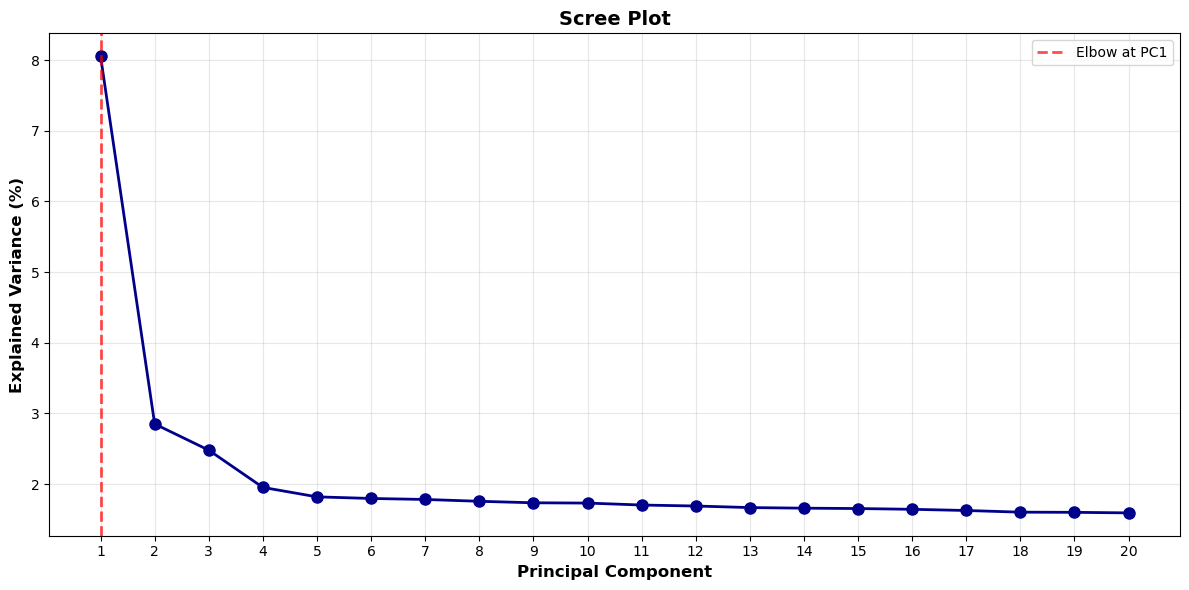

Saved: Latex/Figure/pca_scree_plot.png
Saved: Latex/Figure/pca_scree_plot.pdf

PRINCIPAL COMPONENT LOADINGS

PC1 (explains 8.06% variance)

Top 10 features:
   1. minutes_played                 + 0.4011
   2. games                          + 0.3978
   3. points                         + 0.3883
   4. total_rebounds                 + 0.3558
   5. assists                        + 0.3377
   6. overall_pick                   - 0.2833
   7. free_throw_percentage          + 0.2651
   8. field_goal_percentage          + 0.2486
   9. 3_point_percentage             + 0.2323
  10. year_normalized                - 0.0619

PC2 (explains 2.85% variance)

Top 10 features:
   1. free_throw_percentage          + 0.4165
   2. year_normalized                + 0.4098
   3. 3_point_percentage             + 0.3747
   4. field_goal_percentage          + 0.3734
   5. total_rebounds                 - 0.1920
   6. minutes_played                 - 0.1801
   7. points                         - 0.1773
   8. assist

In [ ]:
from PCA import PCAAnalyzer

# Initialize PCA analyzer
pca_analyzer = PCAAnalyzer(
    output_dir='Data/processed',
    figure_dir='Unsupervised-Machine-Learning-Final-Project/Latex/Figure'
)

# Run complete analysis
pca_analyzer.run_full_analysis(
    X_train=X_train_full,
    X_val=X_val_full,
    feature_names=fe_full.feature_names
)